### Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set a professional style for the plots
sns.set_theme(style="darkgrid")

### Load the Data Files

In [ ]:
STATS_DIR = "prometheus-stats"

# --- Load Baseline Data ---
df_rps_base = pd.read_csv(os.path.join(STATS_DIR, 'baseline_rps_per_pod.csv'))
df_latency_base = pd.read_csv(os.path.join(STATS_DIR, 'baseline_p99_latency_per_pod_ms.csv'))
df_cpu_base = pd.read_csv(os.path.join(STATS_DIR, 'baseline_cpu_usage_per_pod_cores.csv'))

# --- Load AI Run Data ---
df_rps_ai = pd.read_csv(os.path.join(STATS_DIR, 'ai_run_rps_per_pod.csv'))
df_latency_ai = pd.read_csv(os.path.join(STATS_DIR, 'ai_run_p99_latency_per_pod_ms.csv'))
df_cpu_ai = pd.read_csv(os.path.join(STATS_DIR, 'ai_run_cpu_usage_per_pod_cores.csv'))

print("All baseline and AI run data files loaded successfully!")

All baseline and AI run data files loaded successfully!


### Prepare the Data

In [3]:
def prepare_dataframe(df, experiment_name):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['experiment'] = experiment_name
    if 'pod' in df.columns:
        df['version'] = df['pod'].str.extract(r'(v\d+)')
    return df

df_rps_base = prepare_dataframe(df_rps_base, 'Baseline')
df_latency_base = prepare_dataframe(df_latency_base, 'Baseline')
df_cpu_base = prepare_dataframe(df_cpu_base, 'Baseline')

df_rps_ai = prepare_dataframe(df_rps_ai, 'AI-Controlled')
df_latency_ai = prepare_dataframe(df_latency_ai, 'AI-Controlled')
df_cpu_ai = prepare_dataframe(df_cpu_ai, 'AI-Controlled')

# --- Calculate Overall System Latency (Average across pods at each timestamp) ---
system_latency_base = df_latency_base.groupby('timestamp')['value'].mean().reset_index()
system_latency_base['experiment'] = 'Baseline'

system_latency_ai = df_latency_ai.groupby('timestamp')['value'].mean().reset_index()
system_latency_ai['experiment'] = 'AI-Controlled'

# Combine the two system latency dataframes for easy plotting
combined_system_latency = pd.concat([system_latency_base, system_latency_ai])

### Latency Comparison

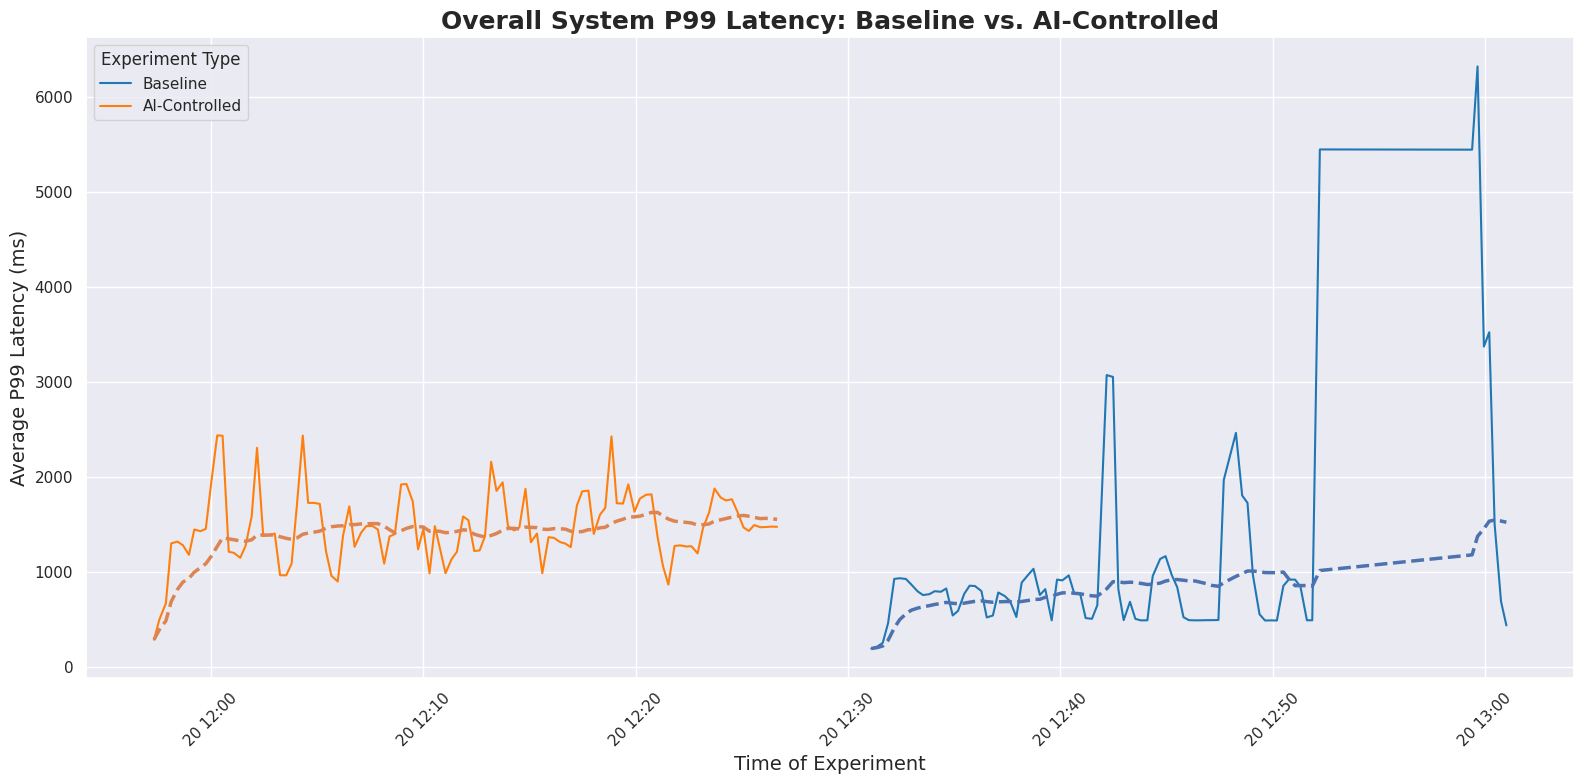

In [4]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=combined_system_latency, x='timestamp', y='value', hue='experiment', palette=['#1f77b4', '#ff7f0e'])

# Add a rolling average to smooth the lines and show the trend
combined_system_latency['rolling_avg'] = combined_system_latency.groupby('experiment')['value'].transform(lambda s: s.rolling(30, min_periods=1).mean())
sns.lineplot(data=combined_system_latency, x='timestamp', y='rolling_avg', hue='experiment', legend=False, linestyle='--', linewidth=2.5)

plt.title('Overall System P99 Latency: Baseline vs. AI-Controlled', fontsize=18, weight='bold')
plt.xlabel('Time of Experiment', fontsize=14)
plt.ylabel('Average P99 Latency (ms)', fontsize=14)
plt.legend(title='Experiment Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(STATS_DIR, 'comparison_latency_graph.png'))
plt.show()

###  Compare Summary Statistics

In [5]:
# --- Baseline Summary ---
avg_latency_base = df_latency_base['value'].mean()
avg_rps_base_total = df_rps_base['value'].sum()

# --- AI Run Summary ---
avg_latency_ai = df_latency_ai['value'].mean()
avg_rps_ai_total = df_rps_ai['value'].sum()

print("="*50)
print("          PERFORMANCE COMPARISON SUMMARY")
print("="*50)
print(f"BASELINE Average P99 Latency:      {avg_latency_base:.2f} ms")
print(f"AI-CONTROLLED Average P99 Latency: {avg_latency_ai:.2f} ms")
print("-"*50)

latency_improvement = ((avg_latency_base - avg_latency_ai) / avg_latency_base) * 100
print(f"Latency Improvement: {latency_improvement:.2f}%")
print("="*50)

          PERFORMANCE COMPARISON SUMMARY
BASELINE Average P99 Latency:      1019.03 ms
AI-CONTROLLED Average P99 Latency: 1467.17 ms
--------------------------------------------------
Latency Improvement: -43.98%
